In [1]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt

### 1. Create Spline Curves and Extrude Them to Form Curved Planes

In [2]:
# Create a spline curve in the x-z plane
def create_spline_curve(points, n_points=100):
    spline = pv.Spline(points, n_points=n_points)
    t_values = np.linspace(0, 1, n_points)
    return spline, t_values

In [3]:
# Generate example points for the spline curve
points = np.array([[-10, 0, 0], [-5, 0, 5], [0, 0, 10], [5, 0, 5], [10, 0, 0]])
spline_curve, t_values = create_spline_curve(points)


In [4]:
# Extrude the spline curve in the y direction to create curved planes
def extrude_spline_curve(spline_curve, extrusion_length):
    extruded = spline_curve.extrude([0, extrusion_length, 0])
    return extruded

In [5]:
extrusion_length = 10  # Length to extrude in the y direction
curved_plane_outer = extrude_spline_curve(spline_curve, extrusion_length)

d:\Users\sunny\anaconda3\envs\env_dps\lib\site-packages\pyvista\core\filters\poly_data.py:2997: PyVistaFutureWarning: The default value of the ``capping`` keyword argument will change in a future version to ``True`` to match the behavior of VTK. We recommend passing the keyword explicitly to prevent future surprises.
  warnings.warn(


In [7]:
# Create a spline curve for the inner part by slightly scaling down the points
inner_points = points * 0.8
spline_curve_inner, t_values_inner = create_spline_curve(inner_points)
curved_plane_inner = extrude_spline_curve(spline_curve_inner, extrusion_length)


d:\Users\sunny\anaconda3\envs\env_dps\lib\site-packages\pyvista\core\filters\poly_data.py:2997: PyVistaFutureWarning: The default value of the ``capping`` keyword argument will change in a future version to ``True`` to match the behavior of VTK. We recommend passing the keyword explicitly to prevent future surprises.
  warnings.warn(


d:\Users\sunny\anaconda3\envs\env_dps\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


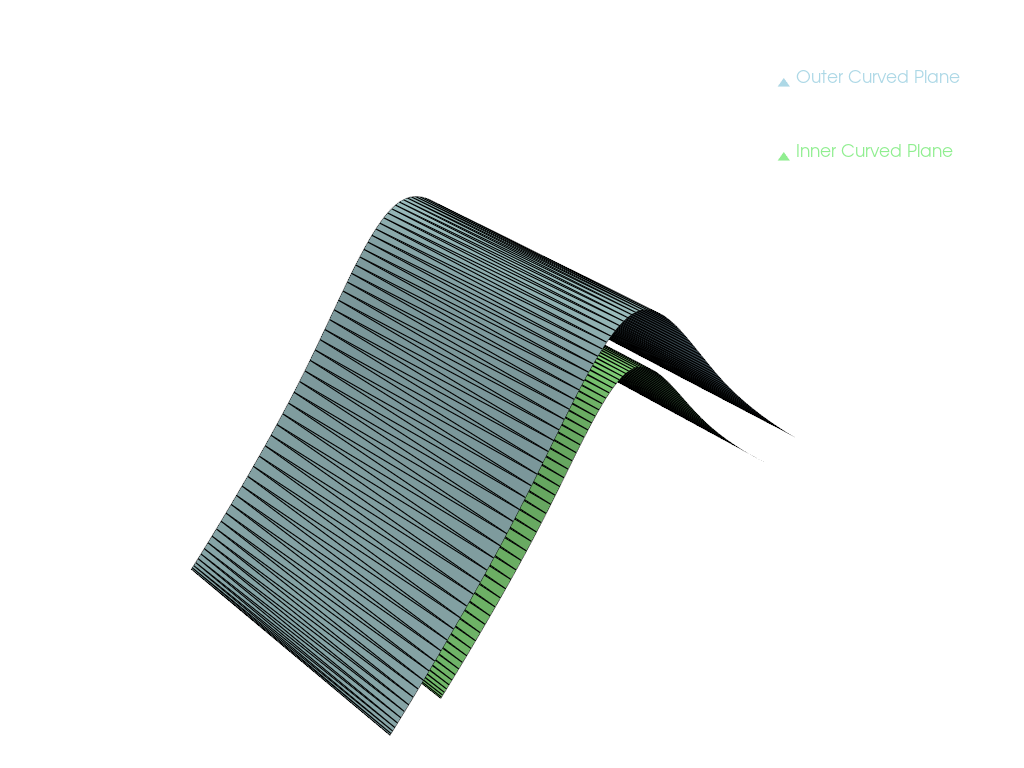

In [8]:
# Visualize the curved planes
plotter = pv.Plotter()
plotter.add_mesh(curved_plane_outer, color='lightblue', show_edges=True, label='Outer Curved Plane')
plotter.add_mesh(curved_plane_inner, color='lightgreen', show_edges=True, label='Inner Curved Plane')
plotter.add_legend()
plotter.show()

### 2. Define the Projection Function with Color Information

In [13]:
# Function to project a mesh onto a curved plane and embed color information
def project_mesh_onto_curve(mesh, curved_plane, t_values, extrusion_length):
    projected_uv = []
    colors = []
    for point, color in zip(mesh.points, mesh.point_data['RGB']):
        closest_point_id = curved_plane.find_closest_point(point)
        t = t_values[closest_point_id % len(t_values)]  # Ensure t_values wrap around correctly
        y = point[1]
        uv = [t, y / extrusion_length]
        projected_uv.append(uv)
        colors.append(color / 255.0)  # Normalize color to [0, 1]
    projected_uv = np.array(projected_uv)
    colors = np.array(colors)
    return projected_uv, colors

### 3. Load the Intraoral Mesh and Apply Projections

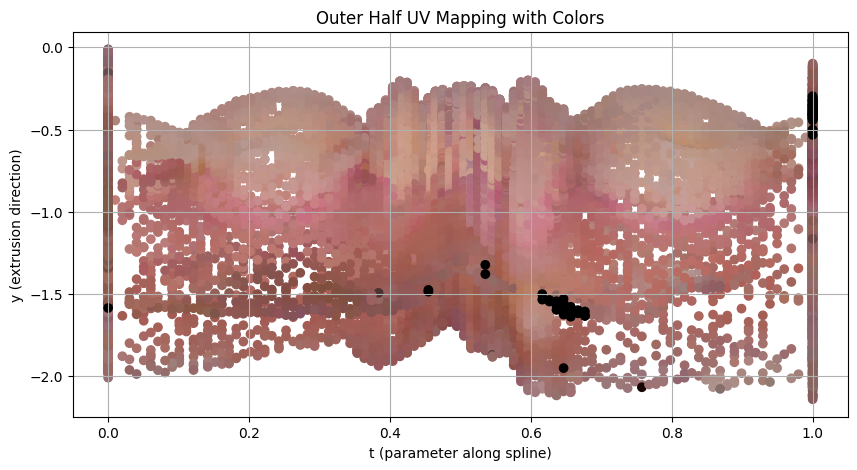

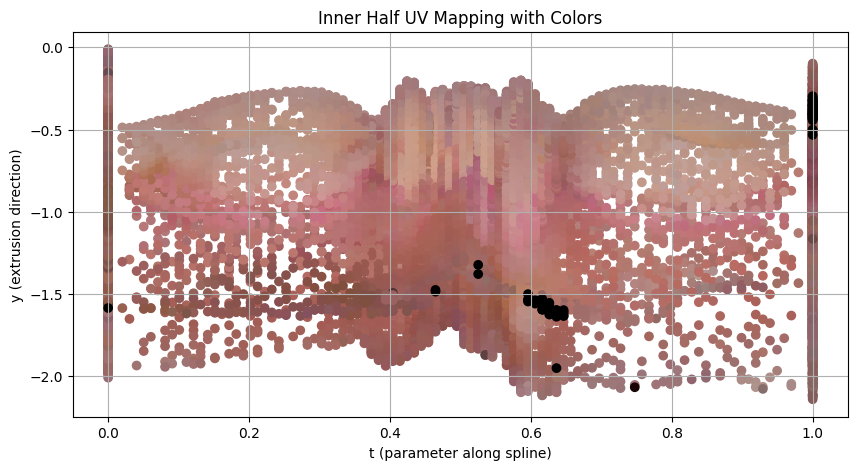

In [14]:
# Load the intraoral mesh
intraoral_mesh = pv.read(r'D:\sunny\Codes\DPS\data\Origin\000101_origin.ply')

# Project the mesh onto the curved planes
projected_outer_uv, colors_outer = project_mesh_onto_curve(intraoral_mesh, curved_plane_outer, t_values, extrusion_length)
projected_inner_uv, colors_inner = project_mesh_onto_curve(intraoral_mesh, curved_plane_inner, t_values_inner, extrusion_length)

# Visualize the projections with color information
def visualize_uv_mapping_with_colors(mesh, uv_coords, colors, title):
    plt.figure(figsize=(10, 5))
    plt.scatter(uv_coords[:, 0], uv_coords[:, 1], c=colors, marker='o')
    plt.title(title)
    plt.xlabel('t (parameter along spline)')
    plt.ylabel('y (extrusion direction)')
    plt.grid(True)
    plt.show()

visualize_uv_mapping_with_colors(intraoral_mesh, projected_outer_uv, colors_outer, 'Outer Half UV Mapping with Colors')
visualize_uv_mapping_with_colors(intraoral_mesh, projected_inner_uv, colors_inner, 'Inner Half UV Mapping with Colors')